In [90]:
import pypyodbc as odbc
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
import matplotlib.pyplot as plt

In [91]:
DRIVER_NAME = "SQL Server"
SERVER_NAME = "DESKTOP-PJBN9BQ\\SQLEXPRESS"
DATABASE_NAME = "Diabetes"

CONNECTION_STRING = f"""
    DRIVER={{{DRIVER_NAME}}};
    SERVER={SERVER_NAME};
    DATABASE={DATABASE_NAME};
    Trust_Connection=yes;
"""

Conn = odbc.connect(CONNECTION_STRING)

In [92]:
cursor = Conn.cursor()
tables_list = list(cursor.tables())

table_name = "diabetes_binary_split_health_indicators_BRFSS2015"
chosen = '"Diabetes_binary","HighBP","HighChol","BMI","Smoker","Stroke","HeartDiseaseorAttack","PhysActivity","HvyAlcoholConsump","GenHlth","DiffWalk","Sex","Age","Education","Income"'
query = "SELECT {} FROM {}".format(chosen, table_name) # SQL qury, filter here not using pandas

cursor.execute(query)
columns = [column[0] for column in cursor.description]
columns[0] = "diabetes"
table = cursor.fetchall()

table_dataframe = pd.DataFrame(table, columns= columns)
for column in columns:
    table_dataframe[str(column)] = table_dataframe[str(column)].astype(float)

#checking if set is balanced
print((len(table_dataframe[table_dataframe["diabetes"] == 1]),len(table_dataframe[table_dataframe["diabetes"] == 0]) ))

(35346, 35346)


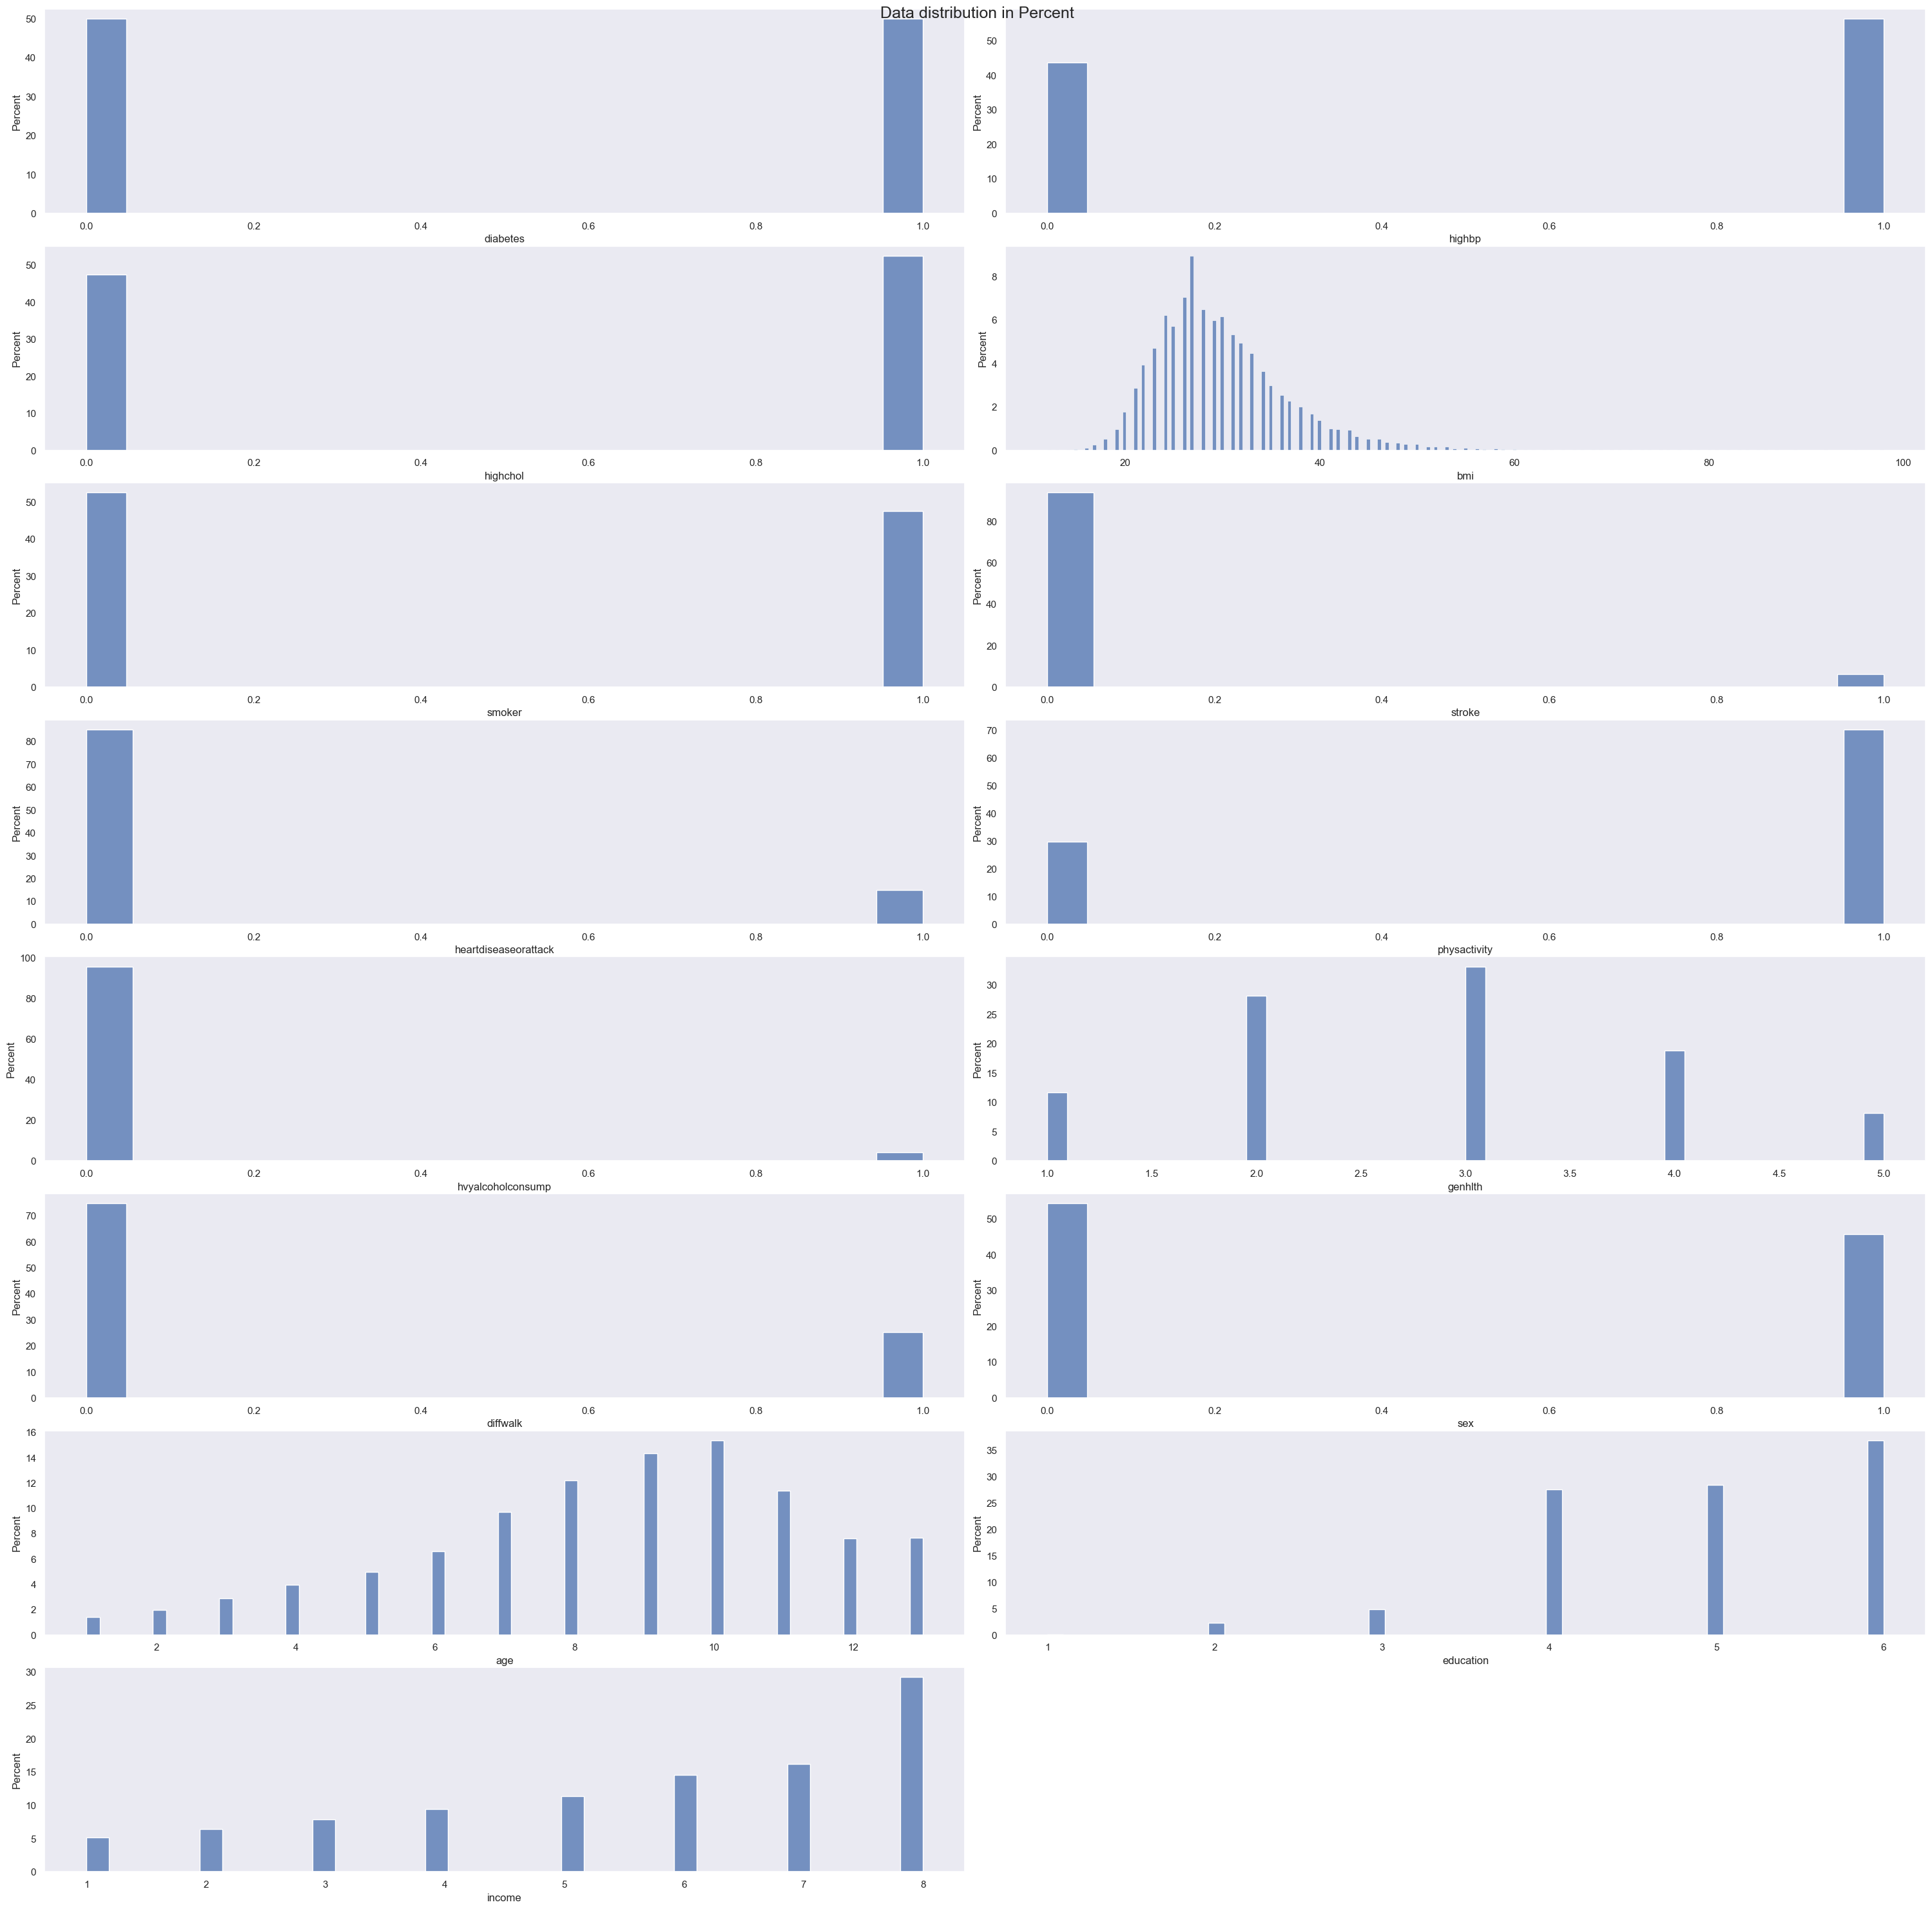

In [141]:
#Data distibution
fig, axs = plt.subplots(len(columns)// 2 + len(columns) % 2,2, figsize = (30,30))
fig.suptitle('Data distribution in Percent', fontsize=18)
fig.tight_layout()
index = 0
for i in range(0, len(columns)// 2+ len(columns) % 2):
    for j in range(0, 2):
        if (index < len(columns)):
            sns.histplot(data = table_dataframe[str(columns[index])], ax = axs[i, j] ,multiple="stack", stat = "percent")
            axs[i,j].set_xlabel(str(columns[index]))
        
        else:
            axs[i,j].remove()
        index += 1



Text(0.5, 1.0, 'Heatmap of correlation')

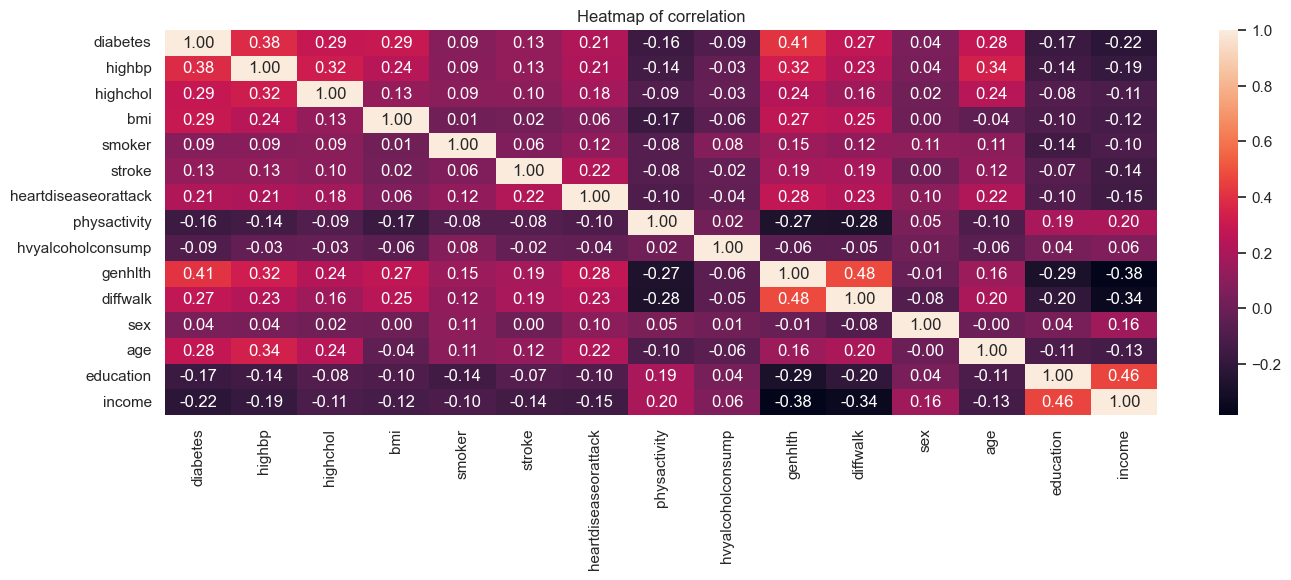

In [94]:
#correlation visualisation
table_dataframe_size = table_dataframe.size

f, axs = plt.subplots(figsize = [16,5])
correlation = table_dataframe.corr()
sns.heatmap(correlation, annot= True,fmt= "0.2f" ,ax = axs)
axs.set_title("Heatmap of correlation")

In [95]:
columns_without_first = columns[1:]
Y = table_dataframe["diabetes"].values
X = table_dataframe[columns_without_first].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 20)


model = Perceptron(max_iter= 15, tol = None, shuffle= True)
model.fit(X_train, Y_train)

Perceptron(max_iter=15, tol=None)

In [96]:
table_dataframe["predicted_value"] = model.predict(table_dataframe[columns_without_first].values)
print(model.score(X, Y))


#sns.scatterplot(result_table)

0.7338029762915181


In [97]:
correct = 0; incorrect = 0
for i in range(len(table_dataframe)):
    if (float(table_dataframe["diabetes"].iloc[i]) == float(table_dataframe["predicted_value"].iloc[i])):
        correct += 1
    else:
        incorrect += 1
        
        
print(f"amount of correct predictions: {correct}")
print(f"amount of INcorrect predictions: {incorrect}")

amount of correct predictions: 51874
amount of INcorrect predictions: 18818


In [98]:
table_dataframe.to_csv("temp.csv", index= False)